In [233]:
# !pip install flopy  

In [234]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy as fp

from IPython.display import Image


In [235]:
modelname = 'mf6_webinar'
modelws = '/mf6_webinar'
path = os.getcwd() # path to current working directory
plt.rcParams ['figure.figsize'] = (5, 5) # default figure size
plt.rcParams ["figure.autolayout"] = True # same as tight_layout




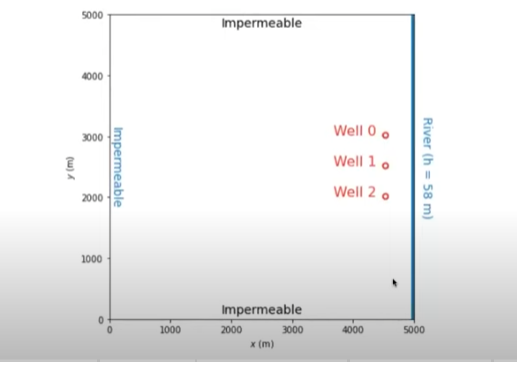

In [236]:
# show image in ./images/1.png

Image("./images/1.png")


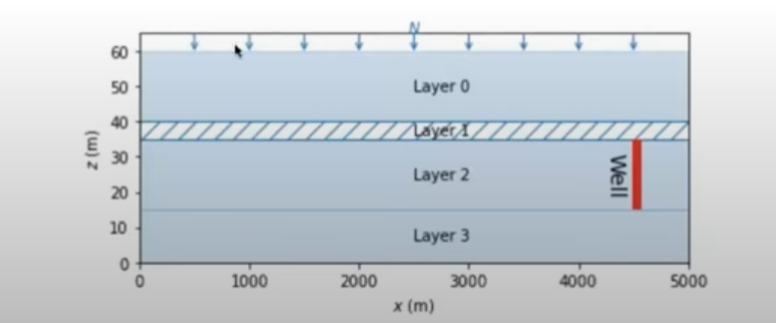

In [237]:
# show image in ./images/2.png

Image("./images/2.png")


# Model parameters

In [238]:
# Grid properties
Lx = 5000 # m
Ly = 5000 # m
ncol = 100
nrow = 100
delc = Lx / ncol
delr = Ly / nrow
# Layers
nlay = 4
top = 60 # top of top layer, m
botm = [40, 35, 15, 0 ] # bottom of each layer, m
# Aquifer properties
k_hor = [20, 0.01, 10, 5] # horizontal hydraulic conductivity, m/d
k_ver = [20, 0.01, 10, 5] # vertical hydraulic conductivity, m/d
porosity = 0.3 # porosity of all layers, -

# Boundary conditions
headriver = 58 # m
Qwell = -3000 # discharge per well, m°3/d (125 m*3/h), negative fo
recharge = 5e-4 # m/d (0.5 mm/ d)

# Create Simulation

In [239]:
sim = fp.mf6.MFSimulation(sim_name=modelname,
version='mf6',
exe_name=path + '/mf6.exe' ,
sim_ws=modelws,
)

Time discretization (Tdis)

In [240]:
tdis_rc = [(1.0, 1, 1.0)] # period length, number of steps,
tdis = fp.mf6.ModflowTdis(sim,
time_units='DAYS' ,
perioddata=tdis_rc,
)

Iterative model solution (Ims)

In [241]:
ims = fp.mf6.ModflowIms (sim,
complexity='SIMPLE',
inner_dvclose=1.e-6,
)

Groundwater flow model (Gwf)

In [242]:
gwf = fp.mf6.ModflowGwf (sim,
modelname=modelname,
model_nam_file=f"{modelname}.nam",
save_flows=True
)

# Add packages to groundwater flow model

Discretization package (Gwfdis) 

In [243]:
dis = fp.mf6.ModflowGwfdis(gwf,
length_units= 'METERS' ,
nlay=nlay,
nrow=nrow,
ncol=ncol,
delr=delr,
delc=delc,
top=top,
botm=botm,
)

Node property flow package (Gwfnpf)

In [244]:
npf = fp.mf6.ModflowGwfnpf(gwf,
save_specific_discharge=True,
icelltype=[1, 0, 0, 0], # top layer
k=k_hor, # horizontal k value
k33=k_ver, # vertical k value
)

Initial conditions (Gwfic)


In [245]:
ic = fp.mf6.ModflowGwfic(gwf,
strt=headriver
)

Specified head package (Gwfchd)

In [246]:
chd_spd = []
for r in range(nrow):
    chd_spd.append ([(0, r, ncol - 1), headriver]) # [(layer, row,
chd = fp.mf6.ModflowGwfchd(gwf,
stress_period_data=chd_spd,

)
    


Recharge package (Gwfrcha)

In [247]:
rch = fp.mf6.ModflowGwfrcha(gwf,
recharge=recharge,
pname='rch' # package name in budget
)

Well package (Gwfwel)

In [248]:
well_row_col = [[40, 90], [50, 90], [60, 90]] # row and column of
wel_spd = []
for rc in well_row_col:
    r = rc [0]
    c = rc[1]
    wel_spd.append([(2, r, c), Qwell]) # [(layer, row, column), di
wel = fp.mf6.ModflowGwfwel(gwf,
stress_period_data=wel_spd,
)

Output control (Gwfoc)

In [249]:
oc = fp.mf6.ModflowGwfoc(gwf,
budget_filerecord=f"{modelname}.cbc",
head_filerecord=f"{modelname}.hds",
saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)

Check input

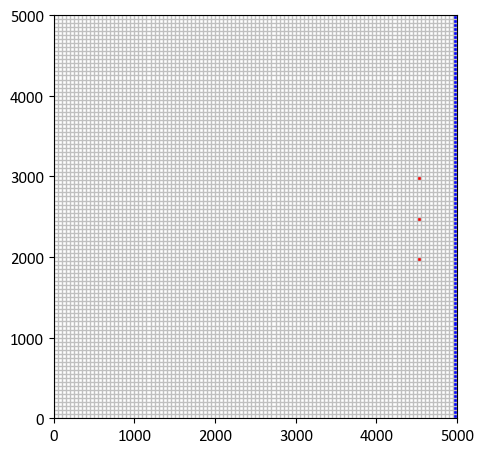

In [250]:
pmv = fp.plot.PlotMapView(model=gwf)
pmv.plot_bc('CHD', color='b')
pmv.plot_bc( 'WEL', plotAll=True, color='r')
pmv.plot_grid(colors='silver', lw=1);

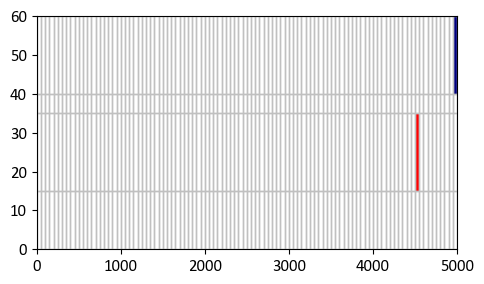

In [251]:
plt.figure(figsize=(5, 3))
pxs = fp.plot.PlotCrossSection( model=gwf, line={'row': 50})
pxs.plot_bc('CHD')
pxs.plot_bc('WEL')
pxs.plot_grid(colors='silver', lw=1)


Solve model

In [252]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6_webinar...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 100 based on size of stress_period_data
    writing package rch...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 3 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\geology\TERM2\MODEL\CODE\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 15:40:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021

(True, [])

# Read and visualize results

Read Heads

In [253]:
fname = os.path.join(modelws, f"{modelname}.hds")
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_data()
print(head.shape)

# min
print('min:', head.min())
# max
print('max:', head.max())

(4, 100, 100)
min: 50.67997794775332
max: 66.09467650422042


Contour plot

Text(0.5, 1.0, 'heads in layer 2')

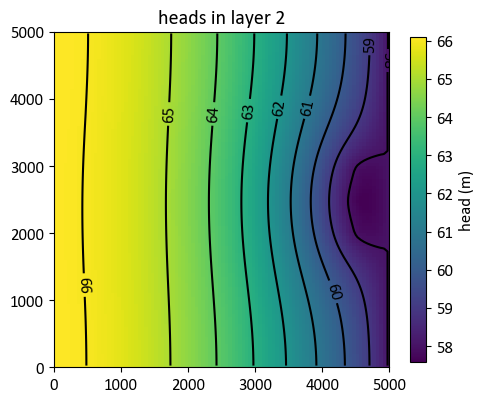

In [270]:
# head in layer 2
pmv = fp.plot.PlotMapView(model=gwf)
qm = pmv. plot_array(head) # color plot of heads
plt.colorbar(qm, shrink=0.7, label='head (m)')
cs = pmv.contour_array(head, levels=range(50, 70), Linewidths=1, colors='black') # contour plot of he
plt.clabel(cs, fmt='%1.0f')
plt.title('heads in layer 2')





Text(0.5, 1.0, 'heads in layer 3')

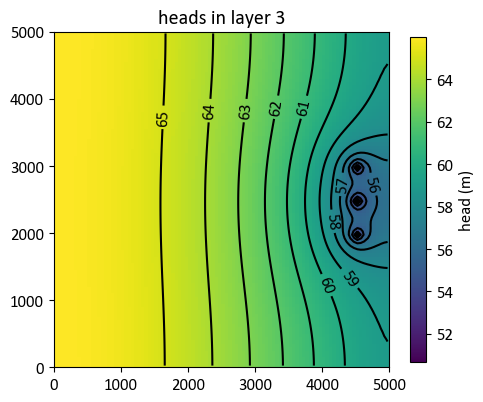

In [272]:
# head in layer 3
pmv = fp.plot.PlotMapView(model=gwf)
qm = pmv. plot_array(head[2]) # color plot of heads
plt.colorbar(qm, shrink=0.7, label='head (m)')
cs = pmv. contour_array(head[2], levels=range(50, 70), Linewidths=1, colors='black') # contour plot of he
plt.clabel(cs, fmt='%1.0f')
plt.title('heads in layer 3')


Text(0.5, 1.0, 'heads in layer 4')

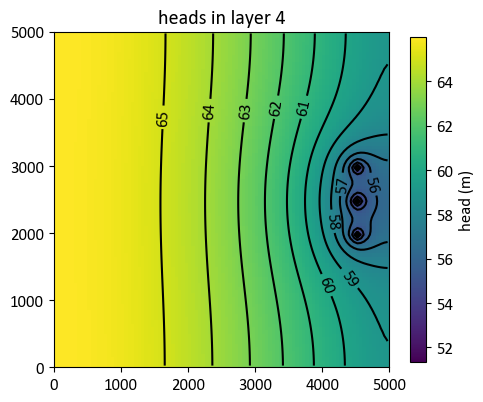

In [273]:
#  head in layer 4
pmv = fp.plot.PlotMapView(model=gwf)
qm = pmv. plot_array(head[3]) # color plot of heads
plt.colorbar(qm, shrink=0.7, label='head (m)')
cs = pmv. contour_array(head[3], levels=range(50, 70), Linewidths=1, colors='black') # contour plot of he
plt.clabel(cs, fmt='%1.0f')
plt.title('heads in layer 4')


Text(0.5, 1.0, 'heads in layer 1')

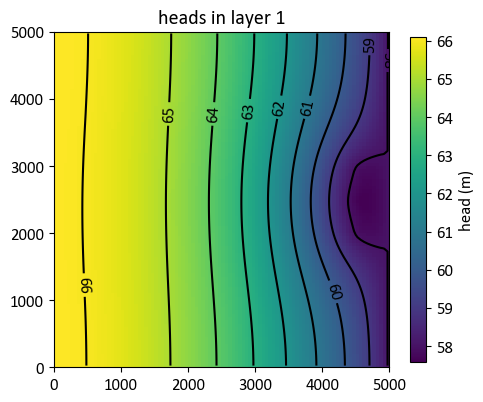

In [274]:
# head in layer 1
pmv = fp.plot.PlotMapView(model=gwf)
qm = pmv. plot_array(head[0]) # color plot of heads
plt.colorbar(qm, shrink=0.7, label='head (m)')
cs = pmv. contour_array(head[0], levels=range(50, 70), Linewidths=1, colors='black') # contour plot of he
plt.clabel(cs, fmt='%1.0f')
plt.title('heads in layer 1')


Water balance

In [258]:
fname = os. path. join(modelws, f"{modelname}.cbc") # file with extension .cbc
cbb = fp.utils.CellBudgetFile(fname)
Qwell = cbb.get_data(text='WEL')[0] # default name or name package name (pname)
Qrch = cbb.get_data(text='RCH' )[0]
Qchd = cbb.get_data(text='CHD' )[0]
Vin = Qrch['q'].sum() # total volume in
Vout = Qwell['q']. sum () + Qchd['q']. sum()
print(f'In: {Vin:.1f} m^3/d')
print(f'Out: {Vout: .1f} m^3/d')
print(f'Relative error {100 * (Vin + Vout) / Vin:.2f} %')

In: 12375.0 m^3/d
Out: -12374.7 m^3/d
Relative error 0.00 %


Read flow and quiver plot

In [259]:
spdis = cbb.get_data(text='DATA-SPDIS' )[0] # returns rec array
qx = spdis["qx"]. reshape(nlay, nrow, ncol)
ay = spdis["qy"].reshape(nlay, nrow, ncol)

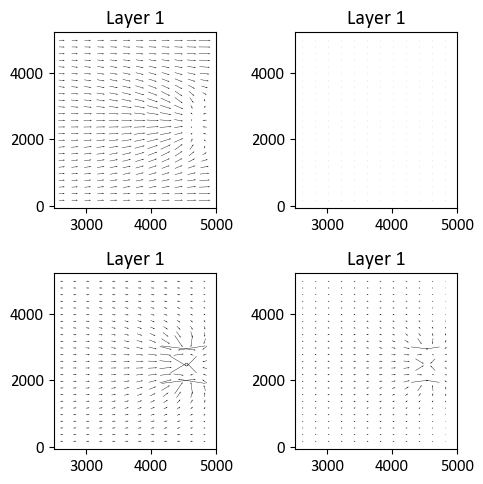

In [265]:
for i in range(nlay):
    ax = plt.subplot (2, 2, i + 1)
    pmv = fp.plot.PlotMapView(model=gwf, layer=i, ax=ax)
    quiver = pmv.plot_vector(qx,
    ay,
    scale=1,
    istep=4,
    jstep=4,
    color="k",
    )
    plt.xlim(Lx / 2, Lx)
    plt. title(f"Layer {1}")
plt.tight_layout()